In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [2]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-08-19 21:12:25--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: 'names.txt'

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2024-08-19 21:12:25 (9.35 MB/s) - 'names.txt' saved [228145/228145]



In [3]:
random.seed(42)

words = open("names.txt", 'r').read().splitlines()
random.shuffle(words)
words[:10]

['yuheng',
 'diondre',
 'xavien',
 'jori',
 'juanluis',
 'erandi',
 'phia',
 'samatha',
 'phoenix',
 'emmelynn']

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {ch:i+1 for i, ch in enumerate(chars)}; stoi['.'] = 0
itos = {i:ch for ch, i in stoi.items()}
vocab_size = len(stoi)
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [109]:
X, y = [], []
block_size = 8

for w in words:
    context = [0]*block_size
    chs = w+'.'
    for ch in chs:
        ix = stoi[ch]
        X.append(context)
        y.append(ix)
        context = context[1:] + [ix]
X = torch.tensor(X)
y = torch.tensor(y)

n1 = int(0.8*len(X))
n2 = int(0.9*len(X))
Xtr, ytr = X[:n1], y[:n1]
Xdev, ydev = X[n1:n2], y[n1:n2]
Xte, yte = X[n2:], y[n2:]
Xte.shape, yte.shape

(torch.Size([22815, 8]), torch.Size([22815]))

In [134]:
class Linear:  
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn(fan_in, fan_out)
        self.bias = torch.randn(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
    
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdims=True)
            xvar = x.var(dim, keepdims=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

        
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

    
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn(num_embeddings, embedding_dim)
        
    def __call__(self, IX):
        self.out =  self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]

    
# class Flatten:
#     def __call__(self, x):
#         self.out = x.view(x.shape[0], -1)
#         return self.out
    
#     def parameters(self):
#         return []

class FlattenConsecutive:
    def __init__(self, n):
        self.n = n
        
    def __call__(self, x):
        B,T,C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    
    
class Sequential:
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [138]:
torch.manual_seed(42)
n_embd = 24
n_hidden = 128

model = Sequential([
    Embedding(vocab_size, n_embd), 
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

76579


In [139]:
# IX = torch.randint(0, Xtr.shape[0], (4,))
# Xb, yb = Xtr[IX], ytr[IX]
# logits = model(Xb)
# for layer in model.layers:
#     print(layer.__class__.__name__, ':', layer.out.shape)

In [140]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, yb = Xtr[ix], ytr[ix]
    
    logits = model(Xb)
    loss = F.cross_entropy(logits, yb)
    
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.item())


      0/ 200000: 4.2088
  10000/ 200000: 2.3178
  20000/ 200000: 2.0349
  30000/ 200000: 1.9200
  40000/ 200000: 1.8440
  50000/ 200000: 2.2962
  60000/ 200000: 2.1133
  70000/ 200000: 2.4919
  80000/ 200000: 1.8896
  90000/ 200000: 2.2352
 100000/ 200000: 1.4588
 110000/ 200000: 2.6603
 120000/ 200000: 2.2909
 130000/ 200000: 2.2251
 140000/ 200000: 2.2312
 150000/ 200000: 2.0562
 160000/ 200000: 1.6570
 170000/ 200000: 2.4663
 180000/ 200000: 1.7110
 190000/ 200000: 2.1516


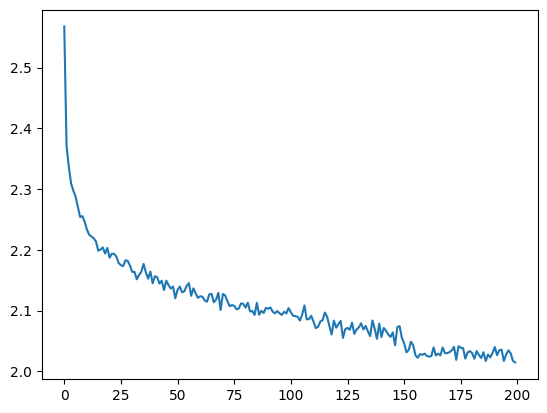

In [141]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

for layer in model.layers:
    layer.training = False

In [142]:
logits = model(Xdev)
loss = F.cross_entropy(logits, ydev)
loss.item()

2.060359477996826

In [144]:
for _ in range(30):
    ix = 0
    context = [ix] * block_size
    name = []
    while True:
        logits = model(torch.tensor([context])) 
        prob = torch.softmax(logits, 1)
        ix = torch.multinomial(prob, num_samples=1).item()
        context = context[1:] + [ix]
        name.append(itos[ix])
        if ix == 0:
            break
    print(''.join(name), end=" | ")

mirson. | celeen. | ellituni. | ayoamelle. | talania. | kenni. | jecionm. | yowsin. | aduriell. | agrisha. | kinah. | avyon. | zantora. | jenithyan. | kaileg. | zani. | juryel. | eshir. | kaeler. | kaylan. | alicea. | orsin. | paussa. | abri. | vera. | jowan. | alaishah. | amilya. | isamara. | skwoe. | 